In [1]:
import glob
import os
import json
import time

import cv2
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from vidgear.gears import WriteGear

from koger_detection.obj_det.mydatasets import VideoDataset
from koger_detection.obj_det.predictors import Predictor

/home/koger/environments/orthocounting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/koger/environments/orthocounting/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from torch import true_divide


video_name = "bear_big2a_2023_08_16_koger_01_01_DJI_20230816175814_0573_D"
video_name = "bear_big-trail_2023_08_16_koger_01_02_DJI_20230816200046_0588_D"
video_folder = "/mnt/e/porcupine-island-2023/drone-flights"
video_file = os.path.join(video_folder, video_name + ".MP4")

if os.path.exists(video_file):
    print(f"video exists")

out_folder = "/mnt/c/Users/benko/Documents/local_projects/bears/videos"
os.makedirs(out_folder, exist_ok=True)

out_name = "test.mp4"


create_video = False

video exists


In [3]:
video_names = sorted(glob.glob(video_file))
print(len(video_names))
print(video_names)

1
['/mnt/e/porcupine-island-2023/drone-flights/bear_big-trail_2023_08_16_koger_01_02_DJI_20230816200046_0588_D.MP4']


In [4]:

load_dotenv()

root = os.environ.get("ROOT")

run_folder = f"/home/koger/Projects/bear-hunting/models/bear-hunting/runs/main"
run_name = "05-14-2025-15-45-22"
cfg_file = os.path.join(run_folder, run_name, "cfg.json") 

with open(cfg_file, "r") as f:
    cfg = json.load(f)
    
cfg_m = cfg['model']
cfg_m['model_weights_pth'] = os.path.join(run_folder, run_name, "final_model.pth")
cfg_m['box_detections_per_img'] = 512
cfg_m['rpn_pre_nms_top_n_test'] = 4000
cfg_m['rpn_post_nms_top_n_test'] = 2000

In [5]:

predictor = Predictor(cfg_m)

In [6]:
ds = VideoDataset(video_file)
data_loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=0)

if create_video:
    output_params = {"-input_framerate": 30,
                    "-pix_fmt": "yuv420p"}
    writer = WriteGear(output=os.path.join(out_folder, out_name),
                    **output_params) 


all_boxes = []
all_scores = []
all_labels = []

t0 = time.time()
first_frame = 0
max_im = None # 10000
for ind, f in enumerate(data_loader):
    if ind < first_frame:
        continue
    if max_im is not None:
        if ind >= max_im:
            break
    if ind % 1000 == 0:
        print(f"Frame number {ind} processed.")
    res = predictor(f[0])
    boxes = res['boxes'].to('cpu').numpy().astype(np.uint32)
    scores = res['scores'].to('cpu').numpy()
    labels = res['labels'].to('cpu').numpy()

    image_name = f"{video_name}-frame-{ind}"

    all_boxes.append(boxes)
    all_scores.append(scores)
    all_labels.append(labels)

    if create_video:
        frame = f[0].numpy().copy() # Copy makes circle work for unclear reasons
        
        for box, score, label in zip(boxes, scores, labels):
            if score < .9:
                continue
            x = np.mean([box[0], box[2]])
            y = np.mean([box[1], box[3]])
            if label == 1:
                cv2.circle(frame, [int(x), int(y)], 4, (4,217,255), -1)
            else:
                cv2.circle(frame, [int(x), int(y)], 8, (255, 0, 0), -1)
        if frame is not None:
            writer.write(frame, rgb_mode=True)
        else:
            print("skipping.")
ds.stop()   
if create_video: 
    writer.close()
total_time = time.time() - t0
print(total_time, f"fps: {ind / total_time}", f"{ind} frames processed.")

np.savez_compressed(os.path.join(out_folder, f"{video_name}-boxes.npz"), *all_boxes)
np.savez_compressed(os.path.join(out_folder, f"{video_name}-scores.npz"), *all_scores)
np.savez_compressed(os.path.join(out_folder, f"{video_name}-labels.npz"), *all_labels)

Frame number 0 processed.
Frame number 1000 processed.
Frame number 2000 processed.
Frame number 3000 processed.
Frame number 4000 processed.
Frame number 5000 processed.
Frame number 6000 processed.
Empty frame. Ending stream.
FileVideoStream stopped.
1170.8008892536163 fps: 5.816531284274445 6810 frames processed.


In [7]:
from yolox.tracker.byte_tracker import BYTETracker

In [8]:
class Arguments:
    def __init__(self):
        self.track_thresh = 0.85
        self.track_buffer = 2
        self.match_thresh = 0.8
        self.min_box_area = 10
        self.frame_rate = 30
        self.mot20 = False
        self.track_id = True
        self.nms = 0.65

args = Arguments()

In [9]:
args.track_thresh

0.85

In [10]:
tracker = BYTETracker(args)

boxes = []
z_boxes = np.load(os.path.join(out_folder, f"{video_name}-boxes.npz"))
z_scores = np.load(os.path.join(out_folder, f"{video_name}-scores.npz"))
z_labels = np.load(os.path.join(out_folder, f"{video_name}-labels.npz"))

tracks = {}

frame_num = 0
for boxes_key, scores_key, labels_key in zip(z_boxes, z_scores, z_labels):
    dets = np.concatenate([z_boxes[boxes_key], 
                           z_scores[scores_key][:, np.newaxis], 
                           z_scores[scores_key][:, np.newaxis],
                           z_labels[labels_key][:, np.newaxis]
                           ], 
                           axis=1)
    online_targets = tracker.update(torch.from_numpy(dets), [2160, 3840], [2160, 3840])

    for strack in online_targets:
        if strack.is_activated:
            track_id = strack.track_id
            if track_id not in tracks:
                tracks[track_id] = {}
            tracks[track_id][strack.frame_id] = strack.tlwh


In [11]:
import pickle

In [12]:
with open(os.path.join(out_folder, f'{video_name}-tracks.pkl'), 'wb') as outp:
    pickle.dump(tracks, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
test = pickle.load(open(os.path.join(out_folder, f'{video_name}-tracks.pkl'), 'rb'))


dict_keys([17039, 17040, 17041, 17042, 17043, 17044, 17045, 17046, 17047, 17048, 17049, 17050, 17051, 17052, 17053, 17054, 17055, 17056, 17057, 17058, 17059, 17060, 17061, 17062, 17063, 17064, 17065, 17066, 17067, 17068, 17069, 17070, 17071, 17072, 17073, 17074, 17075, 17076, 17077, 17078, 17079, 17080, 17081, 17082, 17083, 17084, 17085, 17086, 17087, 17088, 17089, 17090, 17091, 17092, 17093, 17094, 17095, 17096, 17097, 17098, 17099, 17100, 17101, 17102, 17103, 17104, 17105, 17106, 17107, 17108, 17109, 17110, 17111, 17112, 17113, 17114, 17115, 17116, 17117, 17118, 17119, 17120, 17121, 17122, 17123, 17124, 17125, 17126, 17127, 17128, 17129, 17130, 17131, 17132, 17133, 17134, 17135, 17136, 17137, 17138, 17139, 17140, 17141, 17142, 17143, 17144, 17145, 17146, 17147, 17148, 17149, 17150, 17151, 17152, 17154, 17156, 17157, 17158, 17160, 17162, 17164, 17166, 17167, 17168, 17169, 17170, 17175, 17177, 17179, 17180, 17181, 17182, 17183, 17184, 17185, 17186, 17188, 17189, 17190, 17191, 17192, 17

(array([206., 142.,  94.,  67.,  66.,  41.,  37.,  58.,  52.,  46.,  39.,
         26.,  29.,  20.,  21.,  19.,  16.,  12.,  11.,  11.,  11.,   8.,
          8.,   7.,  10.,   8.,  11.,  11.,   9.,   8.,   9.,   6.,   4.,
          3.,   4.,   4.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,
          2.,   0.,   1.,   2.,   1.,   2.,   3.,   2.,   2.,   5.,   4.,
          0.,   2.,   1.,   2.,   1.,   1.,   0.,   0.,   2.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   3.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  11.,   79.,  147.,  215.,  283.,  351.,  419.,  487.,  555.,
         623.,  691.,  759.,  827.,  895.,  963., 1031., 1099., 1167.,
        1235., 1303., 1371., 1439., 1507., 1575., 1643., 1711., 1779.,
        1847., 1915., 1983., 2051., 2119., 2187., 2255., 2323., 2391.,
        2459., 2527., 2595., 2663.

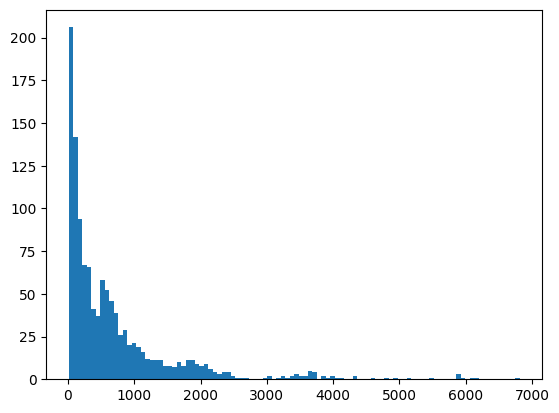

In [13]:
tracks_length = []
for track_id, track in tracks.items():
    if len(track) > 10:
        tracks_length.append(len(track))
plt.hist(tracks_length, bins=100)


In [14]:

import matplotlib as mpl

In [15]:
cmap = mpl.colormaps['tab20']
colors = [(np.array(c) * 255) for c in cmap.colors]


In [16]:
ds = VideoDataset(video_file)
data_loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=0)
out_name = "test-track-2.mp4"

output_params = {"-input_framerate": 30,
                "-pix_fmt": "yuv420p"}
writer = WriteGear(output=os.path.join(out_folder, out_name),
                **output_params) 

t0 = time.time()
first_frame = 0
max_im = None # 10000
for ind, f in enumerate(data_loader):
    if ind < first_frame:
        continue
    if max_im is not None:
        if ind >= max_im:
            break
    if ind % 1000 == 0:
        print(f"Frame number {ind} processed.")

    frame = f[0].numpy().copy() # Copy makes circle work for unclear reasons

    for track_id, track in tracks.items():
        if ind in track:
            box = track[ind]
            x = box[0] + int(box[2] / 2)
            y = box[1] + int(box[3] / 2)
            color = colors[track_id % len(colors)]
            cv2.circle(frame, [int(x), int(y)], 8, (int(color[0]), int(color[1]), int(color[2])), -1)
            cv2.putText(frame, str(track_id), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    if frame is not None:
        writer.write(frame, rgb_mode=True)
    else:
        print("skipping.")

    if ind > 20000:
        break
ds.stop()   

writer.close()
total_time = time.time() - t0
print(total_time, f"fps: {ind / total_time}", f"{ind} frames processed.")

16:57:41 ::   WriteGear   :: WARNING  :: Optional `-disable_ffmpeg_window` flag is only available on Windows OS with `logging=False`. Discarding!


Frame number 0 processed.
Frame number 1000 processed.
Frame number 2000 processed.
Frame number 3000 processed.
Frame number 4000 processed.
Frame number 5000 processed.
Frame number 6000 processed.
Empty frame. Ending stream.
FileVideoStream stopped.
302.2139778137207 fps: 22.533702938775264 6810 frames processed.


In [63]:
type(color[0]), color[1], color[2]

(numpy.int64, 218, 229)

In [49]:
tracks.keys()

dict_keys([12531, 12610, 12630, 12652, 12700, 12713, 12764, 12783, 12784, 12785, 12786, 12787, 12788, 12789, 12790, 12791, 12792, 12793, 12794, 12795, 12796, 12797, 12798, 12799, 12800, 12801, 12802, 12803, 12804, 12805, 12806, 12807, 12808, 12809, 12810, 12811, 12812, 12813, 12814, 12815, 12816, 12817, 12818, 12819, 12820, 12821, 12822, 12823, 12824, 12825, 12826, 12827, 12828, 12829, 12830, 12831, 12832, 12833, 12834, 12835, 12836, 12837, 12838, 12839, 12840, 12841, 12842, 12843, 12844, 12845, 12846, 12847, 12848, 12849, 12850, 12851, 12852, 12853, 12854, 12855, 12856, 12857, 12858, 12859, 12860, 12861, 12862, 12863, 12864, 12865, 12866, 12867, 12868, 12869, 12870, 12871, 12872, 12873, 12874, 12875, 12876, 12877, 12878, 12879, 12880, 12881, 12882, 12883, 12884, 12885, 12886, 12887, 12888, 12889, 12891, 12893, 12894, 12895, 12897, 12899, 12901, 12903, 12904, 12905, 12906, 12907, 12912, 12914, 12916, 12917, 12918, 12919, 12920, 12921, 12922, 12923, 12925, 12926, 12927, 12928, 12929, 12

In [ ]:
create_video = True
for video_file in video_names:
    video_name = os.path.splitext(os.path.basename(video_file))[0]
    out_name = video_name # probably needs .mp4
    ds = VideoDataset(video_file)
    data_loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=0)

    if create_video:
        output_params = {"-input_framerate": 30,
                    "-pix_fmt": "yuv420p"}
        writer = WriteGear(output=os.path.join(out_folder, out_name),
                        **output_params) 


    all_boxes = []
    all_scores = []

    t0 = time.time()
    first_frame = 0
    max_im = None # 10000
    for ind, f in enumerate(data_loader):
        if ind < first_frame:
            continue
        if max_im is not None:
            if ind >= max_im:
                break
        if ind % 1000 == 0:
            print(f"Frame number {ind} processed.")
        res = predictor(f[0])
        boxes = res['boxes'].to('cpu').numpy().astype(np.uint32)
        scores = res['scores'].to('cpu').numpy()
        labels = res['labels'].to('cpu').numpy()

        image_name = f"{video_name}-frame-{ind}"

        all_boxes.append(boxes)
        all_scores.append(scores)

        if create_video:
            frame = f[0].numpy().copy() # Copy makes circle work for unclear reasons
            
            for box, score, label in zip(boxes, scores, labels):
                if score < .9:
                    continue
                x = np.mean([box[0], box[2]])
                y = np.mean([box[1], box[3]])
                if label == 1:
                    cv2.circle(frame, [int(x), int(y)], 4, (4,217,255), -1)
                else:
                    cv2.circle(frame, [int(x), int(y)], 8, (255, 0, 0), -1)
            if frame is not None:
                writer.write(frame[:720, :1280], rgb_mode=True)
            else:
                print("skipping.")
    ds.stop()   
    if create_video: 
        writer.close()
    total_time = time.time() - t0
    print(total_time, f"fps: {ind / total_time}", f"{ind} frames processed.")

    np.savez_compressed(os.path.join(out_folder, f"{video_name}-boxes.npz"), *all_boxes)
    np.savez_compressed(os.path.join(out_folder, f"{video_name}-scores.npz"), *all_scores)

17:33:53 ::   WriteGear   :: WARNING  :: Optional `-disable_ffmpeg_window` flag is only available on Windows OS with `logging=False`. Discarding!


Frame number 0 processed.


17:33:54 ::   WriteGear   ::  ERROR   :: BrokenPipeError caught, Wrong values passed to FFmpeg Pipe. Kindly Refer Docs!


ValueError: 

In [8]:
output_params = {"-input_framerate": 30,
# }
                "-pix_fmt": "yuv420p"}
writer = WriteGear(output=os.path.join(out_folder, out_name),
                **output_params) 

for i in range(300):
    writer.write(np.ones((400, 400, 3)), rgb_mode=True)

writer.close()



17:23:37 ::   WriteGear   :: WARNING  :: Optional `-disable_ffmpeg_window` flag is only available on Windows OS with `logging=False`. Discarding!
17:23:37 ::   WriteGear   ::  ERROR   :: BrokenPipeError caught, Wrong values passed to FFmpeg Pipe. Kindly Refer Docs!


ValueError: 

In [30]:
np.savez_compressed(os.path.join(out_folder, f"{video_name}-allboxes.npz"), *all_boxes)
np.savez_compressed(os.path.join(out_folder, f"{video_name}-allscores.npz"), *all_scores)

In [17]:
os.path.join(out_folder, f"{video_name}-allboxes.npz")

'/mnt/c/Users/benko/Dropbox/Dungeness_smolt_outflow/videos/2024/100TLC2K/output/A_TLC00001-allboxes.npz'

In [36]:
boxes = []
z = np.load(os.path.join(out_folder, f"{video_name}-boxes.npz"))
for key in z:
    boxes.append(z[key])

scores = []
z = np.load(os.path.join(out_folder, f"{video_name}-scores.npz"))
for key in z:
    scores.append(z[key])


In [39]:
thresh = .7
counts = []
for frame_boxes, frame_scores in zip(boxes, scores):
    mask = frame_scores > thresh
    count = np.sum(mask)
    counts.append(count)

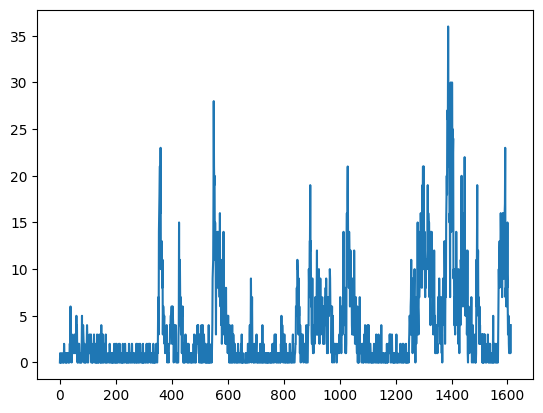

In [40]:
plt.plot(counts)

In [38]:
scores[0] >.8

array([False, False, False, False, False, False])